In [777]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

# Génération des données avec bruit Gaussien :

In [778]:
def get_data(n_samples : int = 1000, noise : float = 3, name = 'linear', test=False):
    
    if test:
        if name == 'linear':
            x = np.linspace(-5, 5, n_samples)
            y = x**3 + np.random.randn(len(x))*noise
            X_test = (x, y)
            y = x**3
            X_true = (x, y)
            return X_test, X_true
        
    if name == 'linear':
        x = np.linspace(-5, 5, n_samples)
        y = x**3 + np.random.randn(len(x))*noise
        return x, y

    
    if name == 'batman':
        x = np.linspace(-7, 7, n_samples)
        H = lambda x: np.heaviside(x, 0.5)
        sqrt = lambda x: np.sqrt(np.maximum(x, 0.0))

        w = 3 * sqrt(1 - (x / 7) ** 2)
        l = (
            0.5 * (x + 3) - 3 / 7 * sqrt(10 * (4 - (x + 1) ** 2)) + 6 / 7 * sqrt(10)
        )
        h = 0.5 * (
            3 * (np.abs(x + 0.5) + np.abs(x - 0.5) + 6)
            - 11 * (np.abs(x - 0.75) + np.abs(x + 0.75))
        )
        r = 0.5 * (3 - x) - 3 / 7 * sqrt(10 * (4 - (x - 1) ** 2)) + 6 / 7 * sqrt(10)

        upper = np.where(
            np.abs(x) > 7,
            np.nan,
            (
                (h - l) * H(x + 1)
                + (r - h) * H(x - 1)
                + (l - w) * H(x + 3)
                + (w - r) * H(x - 3)
                + w
            ),
        )
        lower = np.where(
            np.abs(x) > 7,
            np.nan,
            0.5
            * (
                np.abs(0.5 * x)
                + sqrt(1 - (np.abs(np.abs(x) - 2) - 1) ** 2)
                - (3 * sqrt(33) - 7) / 112 * x**2
                + 3 * sqrt(1 - (x / 7) ** 2)
                - 3
            )
            * (np.sign(x + 4) - np.sign(x - 4))
            - 3 * sqrt(1 - (x / 7) ** 2),
        )

        upper = upper + np.random.normal(0, noise, x.size)
        lower = lower + np.random.normal(0, noise, x.size)
        
    return upper, lower, x

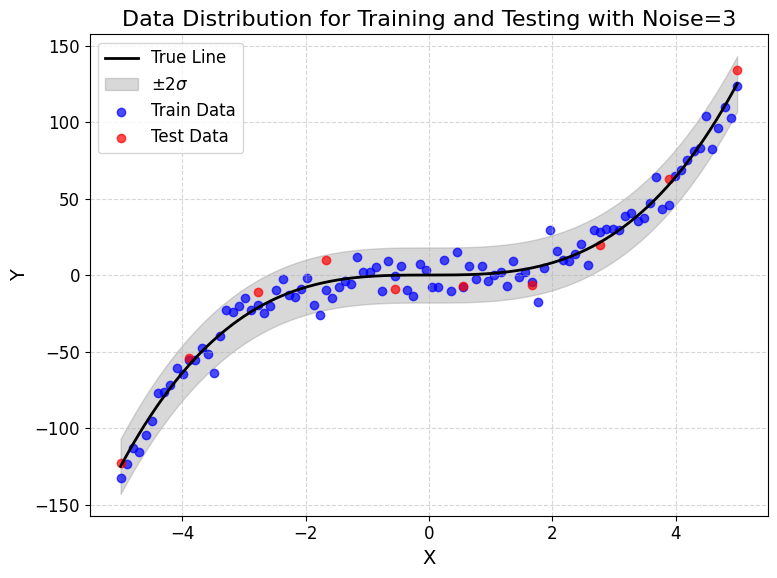

In [779]:
noise = 9
x, y = get_data(n_samples=1000, noise=0)
x_train, y_train = get_data(n_samples=100, noise=noise)
x_val, y_val = get_data(n_samples=10, noise=noise)
test_data, true_data = get_data(n_samples=10, noise=noise, test=True)

x_test, y_test = test_data
x_true_data, y_true_data = true_data

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, label='True Line', color='black', linewidth=2)
ax.fill_between(x, y - 2*noise, y + 2*noise, color='gray', alpha=0.3, label=r'$\pm 2\sigma$')
ax.scatter(x_train, y_train, label='Train Data', color='blue', alpha=0.7, marker='o')
ax.scatter(x_test, y_test, label='Test Data', color='red', alpha=0.7, marker='o')
ax.set_title('Data Distribution for Training and Testing with Noise=3', fontsize=16)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Normalisation des données pour la stabilité du modèle :

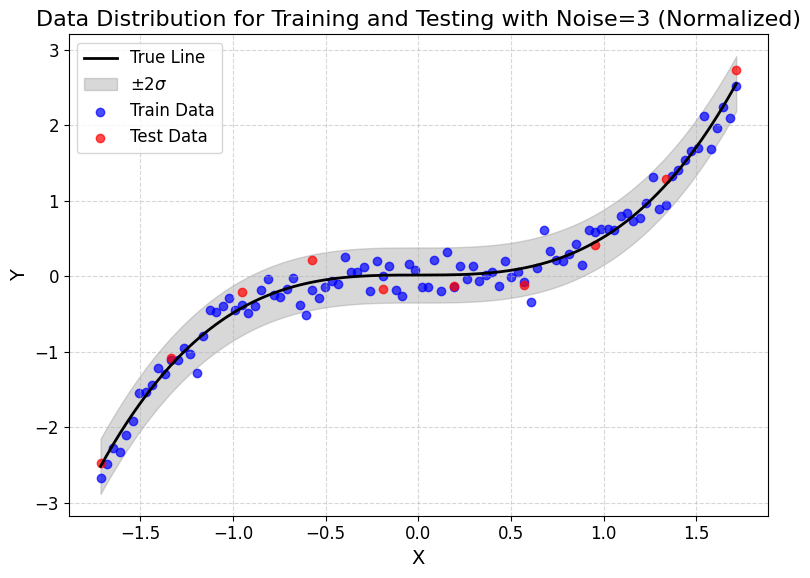

In [780]:
x_train_norm = (x_train - np.mean(x_train)) / np.std(x_train)
y_train_norm = (y_train - np.mean(y_train)) / np.std(y_train)
x_test_norm = (x_test - np.mean(x_train)) / np.std(x_train)
y_test_norm = (y_test - np.mean(y_train)) / np.std(y_train)
x_val_norm = (x_val - np.mean(x_train)) / np.std(x_train)
y_val_norm = (y_val - np.mean(y_train)) / np.std(y_train)
x_norm = (x - np.mean(x_train)) / np.std(x_train)
y_norm = (y - np.mean(y_train)) / np.std(y_train)

standardized_noise = noise / np.std(y_train)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_norm, y_norm, label='True Line', color='black', linewidth=2)
ax.fill_between(x_norm, y_norm - 2*standardized_noise, y_norm + 2*standardized_noise, color='gray', alpha=0.3, label=r'$\pm 2\sigma$')
ax.scatter(x_train_norm, y_train_norm, label='Train Data', color='blue', alpha=0.7, marker='o')
ax.scatter(x_test_norm, y_test_norm, label='Test Data', color='red', alpha=0.7, marker='o')
ax.set_title('Data Distribution for Training and Testing with Noise=3 (Normalized)', fontsize=16)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# TAGI - Implémentation

## Définition des fonctions :

### Initialisation des paramètres 

In [781]:
def initialize_params(layer_dims, seed = None):
    '''
    Initializes the weights of the neural network.
    
    Inputs :
    layer_dims : list of integers, where the ith element is the number of neurons in the ith layer.
    seed : int, random seed for reproducibility.
    
    Outputs :
    parameters : dictionary containing the weights of the neural network.
    '''
    
    if not all(isinstance(dim, int) for dim in layer_dims):
        raise ValueError("All elements in layer_dims must be integers.")
    
    if seed is not None:
        np.random.seed(seed)
    
    parameters = {}
    L = len(layer_dims) - 1
    
    for l in range(0, L):
        
        mu_w = np.random.normal(0, (np.sqrt(1/layer_dims[l])), (layer_dims[l+1], layer_dims[l]))
        var_w = np.ones((layer_dims[l+1], layer_dims[l]))* 1 / (layer_dims[l])
        
        mu_b = np.random.normal(0, (np.sqrt(1/layer_dims[l])), (layer_dims[l+1], 1))
        var_b = np.ones((layer_dims[l+1], 1)) * (1 / (layer_dims[l]))
        
        mu_theta = np.concatenate((mu_w, mu_b), axis=1)
        var_theta = np.concatenate((var_w, var_b), axis=1)
        parameters[f'theta_{l}'] = (mu_theta, var_theta)

    return parameters

### Feedforward

In [782]:
def layer_1_forward(A_prev, theta_prev):
    '''
    Implements the forward propagation for a single layer.
    
    Inputs :
    A_prev : numpy array, activations from the previous layer.
    theta : tuple, weights and biases for the current layer.
    
    Outputs :
    A : numpy array, activations for the current layer.
    cache : tuple, contains the activations from the previous layer and the current layer.
    '''
    
    mu_z = A_prev[0] * theta_prev[0][:,:-1] + theta_prev[0][:,-1].reshape(-1, 1)
    var_z = A_prev[0]**2 * theta_prev[1][:,:-1] + theta_prev[1][:,-1].reshape(-1, 1)
    cov_z_w = A_prev[0] * theta_prev[1][:,:-1]
    cov_z_b = theta_prev[1][:,-1].reshape(-1, 1)
    
    cov_z_theta = np.concatenate((cov_z_w, cov_z_b), axis=1)
    
    return (mu_z, var_z, cov_z_theta)

In [783]:
def activation_forward(Z):
    mu_z, var_z, _ = Z
    
    T = np.where(mu_z > 0, 1, 0)
    mu_a = mu_z * T
    var_a = var_z * T
    
    return (mu_a, var_a, T)

In [784]:
def layer_2_forward(A_prev, theta_prev):
    '''
    Implements the forward propagation for the second layer.
    
    Inputs :
    A_prev : numpy array, activations from the previous layer.
    theta : tuple, weights and biases for the current layer.
    
    Outputs :
    A : numpy array, activations for the current layer.
    cache : tuple, contains the activations from the previous layer and the current layer.
    '''
    mu_a, var_a, _ = A_prev
    mu_w, mu_b = theta_prev[0][:,:-1], theta_prev[0][:,-1].reshape(-1, 1)
    var_w, var_b = theta_prev[1][:,:-1], theta_prev[1][:,-1].reshape(-1, 1)
    
    mu_z = mu_w @ mu_a + mu_b
    var_z = var_w @ var_a + var_w @ mu_a**2 + mu_w**2 @ var_a + var_b

    cov_z_w = theta_prev[1][:,:-1] * A_prev[0].T
    cov_z_b = theta_prev[1][:,-1].reshape(-1, 1)
    
    cov_z_theta = np.concatenate((cov_z_w, cov_z_b), axis=1)
    
    return (mu_z, var_z, cov_z_theta)

### Modèle d'observation

In [785]:
def obs_model(Z_out, var_v):
    # get y
    mu_z0, var_z0, _ = Z_out
    mu_y = mu_z0
    var_y = var_z0 + var_v
    
    return (mu_y, var_y)

In [786]:
def log_likelihood(Y, y):
    mu_y, var_y = Y
    mu_y = mu_y.flatten()[0]
    var_y = var_y.flatten()[0]
    return -0.5 * np.log(2 * np.pi) - 0.5 * np.log(var_y) - 0.5 * (y - mu_y)**2 / var_y 

In [787]:
def update_output(Y, Z_out, y):
    mu_y, var_y = Y
    mu_z0, var_z0, _ = Z_out
    
    mu_z_y = mu_z0 + (var_z0/var_y) * (y - mu_y)
    var_z_y = var_z0 - (var_z0**2/var_y)

    return (mu_z_y, var_z_y)

### Inférence

In [788]:
def update_hidden_layer(Z, Z_out, Z_out_y, A, theta):
    
    mu_z, var_z, _ = Z
    mu_z_out, var_z_out, _ = Z_out
    mu_z_out_y, var_z_out_y = Z_out_y
    _, _, T = A
    mu_w = theta[0][:,:-1]
    
    cov_z_z_out = var_z.T * T.T * mu_w
    Jz = cov_z_z_out / var_z_out
    mu_z_y = mu_z + Jz.T * (mu_z_out_y - mu_z_out)
    var_z_y = var_z + Jz.T * (var_z_out_y - var_z_out) * Jz.T
    
    return (mu_z_y, var_z_y)

In [789]:
def update_parameters1(Z_out, Z_out_y, theta1):
    
    mu_z_out, var_z_out, cov_z_out_theta = Z_out
    cov_z_out_w, cov_z_out_b = cov_z_out_theta[:,:-1], cov_z_out_theta[:,-1].reshape(-1, 1)
    
    mu_z_out_y, var_z_out_y = Z_out_y
    mu_w, mu_b = theta1[0][:,:-1], theta1[0][:,-1].reshape(-1, 1)
    var_w, var_b = theta1[1][:,:-1], theta1[1][:,-1].reshape(-1, 1)
    
    Jw = cov_z_out_w/var_z_out
    mu_w_y = mu_w + Jw * (mu_z_out_y - mu_z_out)
    var_w_y = var_w + Jw * (var_z_out_y - var_z_out) * Jw
    
    Jb = cov_z_out_b/var_z_out
    mu_b_y = mu_b + Jb * (mu_z_out_y - mu_z_out)
    var_b_y = var_b + Jb * (var_z_out_y - var_z_out) * Jb
    
    mu_theta = np.concatenate((mu_w_y, mu_b_y), axis=1)
    var_theta = np.concatenate((var_w_y, var_b_y), axis=1)
    
    return (mu_theta, var_theta)

In [790]:
def update_parameters0(Z, Z_y, theta0):
    
    mu_z, var_z, cov_z_theta = Z
    cov_z_w, cov_z_b = cov_z_theta[:,:-1], cov_z_theta[:,-1].reshape(-1, 1)
    
    mu_z_out_y, var_z_out_y = Z_y
    mu_w, mu_b = theta0[0][:,:-1], theta0[0][:,-1].reshape(-1, 1)
    var_w, var_b = theta0[1][:,:-1], theta0[1][:,-1].reshape(-1, 1)
    
    Jw = cov_z_w/var_z
    mu_w_y = mu_w + Jw * (mu_z_out_y - mu_z)
    var_w_y = var_w + Jw * (var_z_out_y - var_z) * Jw
    
    Jb = cov_z_b/var_z
    mu_b_y = mu_b + Jb * (mu_z_out_y - mu_z)
    var_b_y = var_b + Jb * (var_z_out_y - var_z) * Jb
    
    mu_theta = np.concatenate((mu_w_y, mu_b_y), axis=1)
    var_theta = np.concatenate((var_w_y, var_b_y), axis=1)
    
    return (mu_theta, var_theta)

### Entrainement

In [791]:
# define the architecture of the neural network
layer_dims = [1, 350, 1]
parameters = initialize_params(layer_dims, seed=42)
best_params = parameters.copy()
# define the number of epochs
n_epochs = 100
log_ll_train = []
log_ll_val = []
log_ref = 0

# train the modela
for epoch in tqdm(range(n_epochs)):
    log_likelihood_train = 0
    for x, y in zip(x_train_norm,y_train_norm):
        
        A_0 = (np.array([[x]]),np.array([[0]]))
        
        Z_1 = layer_1_forward(A_0, parameters["theta_0"])

        A_1 = activation_forward(Z_1)
        
        Z_out = layer_2_forward(A_1, parameters["theta_1"])

        Y = obs_model(Z_out, standardized_noise**2)

        log_likelihood_train += log_likelihood(Y, y)
        
        Z_out_y = update_output(Y, Z_out, y)

        Z_1_y = update_hidden_layer(Z_1, Z_out, Z_out_y, A_1, parameters["theta_1"])

        theta_1_y = update_parameters1(Z_out, Z_out_y, parameters["theta_1"])
        theta_0_y = update_parameters0(Z_1, Z_1_y, parameters["theta_0"])
        
        parameters["theta_1"] = theta_1_y
        parameters["theta_0"] = theta_0_y

    log_ll_train.append(log_likelihood_train/len(x_train))

    # evaluate the model on the validation data
    log_likelihood_val = 0
    y_val = []
    var_val = []
    for x, y in zip(x_val_norm, y_val_norm):
        # apply the forward pass from input to hidden layer
        A_0 = (np.array([[x]]),np.array([[0]]))
        
        Z_1 = layer_1_forward(A_0, parameters["theta_0"])

        A_1 = activation_forward(Z_1)
        
        Z_out = layer_2_forward(A_1, parameters["theta_1"])

        Y = obs_model(Z_out, standardized_noise**2)

        log_likelihood_val += log_likelihood(Y, y)

        mu_y, var_y = Y
        y_val.append(mu_y.flatten()[0])
        var_val.append(var_y.flatten()[0])
    # append the log likelihood
    log_ll_val.append(log_likelihood_val/len(x_val))
    
    if log_ll_val[-1] > log_ref:
        log_ref = log_ll_val[-1]
        best_params = parameters.copy()

# check at which epoch the log likelihood for the test data is the highest
print('Epoch with the highest log likelihood:', np.argmax(log_ll_val))

100%|██████████| 100/100 [00:00<00:00, 157.39it/s]

Epoch with the highest log likelihood: 98


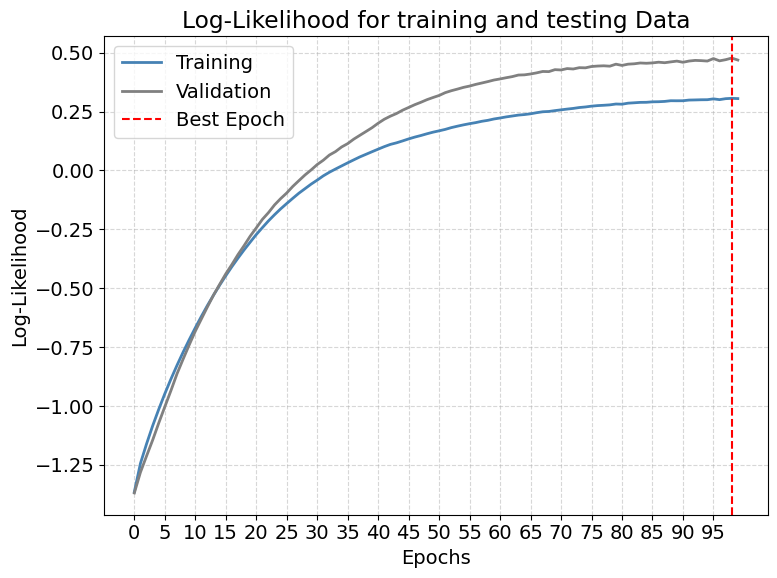

In [792]:
# Plot
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})  # Update font size

# Log-likelihood curve for training data
plt.plot(log_ll_train, label='Training', color='steelblue', linewidth=2)

# Log-likelihood curve for testing data
plt.plot(log_ll_val, label='Validation', color='grey', linewidth=2)

# Vertical line to indicate the epoch with maximum log-likelihood
best_epoch = np.argmax(log_ll_val)
plt.axvline(best_epoch, color='red', linestyle='--', label='Best Epoch')

# Labels and legend
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood for training and testing Data')
plt.xticks(np.arange(0, n_epochs, 5))  # Set ticks for every 5 epochs
plt.legend()

# Grid
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()  
plt.show()

In [793]:
# define the number of epochs
n_epochs = np.argmax(log_ll_val)
log_ll_train = []
log_ll_val = []
log_ref = 0

# train the modela
for epoch in tqdm(range(n_epochs)):
    # evaluate the model on the validation data
    log_likelihood_val = 0
    y_pred = []
    var_pred = []
    for x, y in zip(x_test_norm, y_test_norm):
        # apply the forward pass from input to hidden layer
        A_0 = (np.array([[x]]),np.array([[0]]))
        
        Z_1 = layer_1_forward(A_0, best_params["theta_0"])

        A_1 = activation_forward(Z_1)
        
        Z_out = layer_2_forward(A_1, best_params["theta_1"])

        Y = obs_model(Z_out, standardized_noise**2)

        log_likelihood_val += log_likelihood(Y, y)

        mu_y, var_y = Y
        y_pred.append(mu_y.flatten()[0])
        var_pred.append(var_y.flatten()[0])

100%|██████████| 98/98 [00:00<00:00, 3197.47it/s]


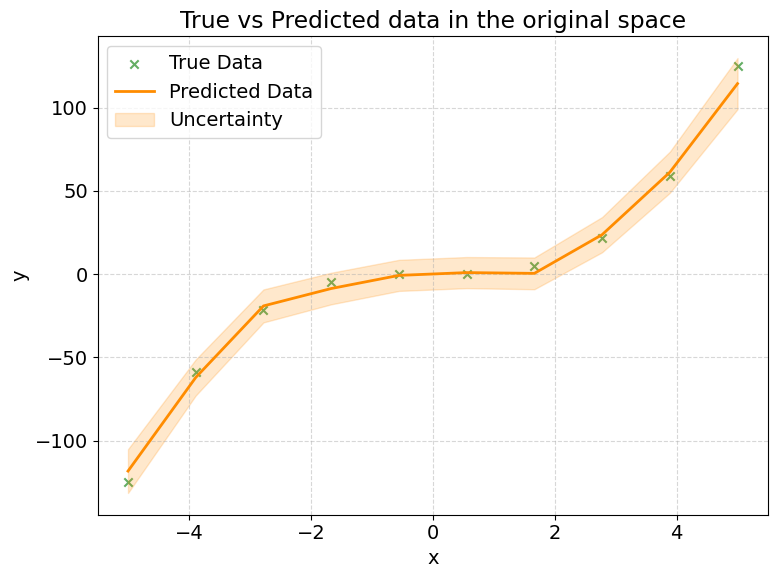

In [794]:
y_pred_orig = np.array(y_pred) * np.std(y_train) + np.mean(y_train)
var_pred_orig = np.array(var_pred) * np.std(y_train)**2

# Plot the results in standard space
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

# Scatter plot for true data
plt.scatter(x_true_data, y_true_data, label='True Data', color='forestgreen', alpha=0.7, marker='x')

# Line plot for predicted data
plt.plot(x_test, y_pred_orig, label='Predicted Data', color='darkorange', linewidth=2)

# Fill between for uncertainty
plt.fill_between(x_test, np.array(y_pred_orig) - np.sqrt(var_pred_orig), np.array(y_pred_orig) + np.sqrt(var_pred_orig), alpha=0.2, label='Uncertainty', color='darkorange')

# Labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('True vs Predicted data in the original space')
plt.legend()

# Grid
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()

## Métrique de performance - dataset de test et true dataset

In [795]:
# Test data
# Calcule des métriques.
mse = mean_squared_error(y_test, y_pred_orig)
mae = mean_absolute_error(y_test, y_pred_orig)
r2 = r2_score(y_test, y_pred_orig)

# Afficher les métriques.
print("Metrics:")
print("{:<20} {:.2f}".format("Mean Squared Error:", mse))
print("{:<20} {:.2f}".format("Mean Absolute Error:", mae))
print("{:<20} {:.2f}".format("R-squared:", r2))

Metrics:
Mean Squared Error:  106.84
Mean Absolute Error: 8.78
R-squared:           0.97


In [796]:
# True data and predicted data
# Calcule des métriques.
mse = mean_squared_error(y_pred_orig, y_true_data)
mae = mean_absolute_error(y_pred_orig, y_true_data)
r2 = r2_score(y_pred_orig, y_true_data)

# Afficher les métriques.
print("Metrics:")
print("{:<20} {:.2f}".format("Mean Squared Error:", mse))
print("{:<20} {:.2f}".format("Mean Absolute Error:", mae))
print("{:<20} {:.2f}".format("R-squared:", r2))

Metrics:
Mean Squared Error:  21.89
Mean Absolute Error: 3.70
R-squared:           0.99


## PyTorch MLP

350
Best epoch: 66


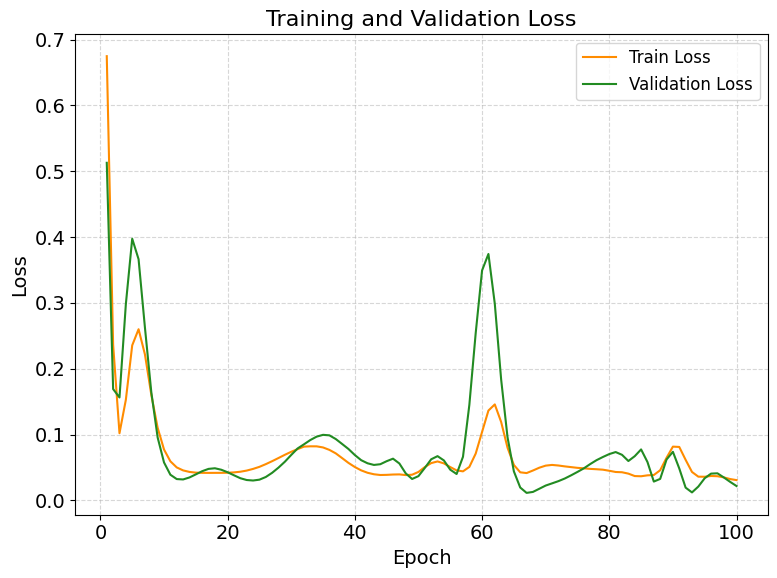

In [797]:
x_train_norm = torch.tensor(x_train_norm, dtype=torch.float32)
y_train_norm = torch.tensor(y_train_norm, dtype=torch.float32)
x_val_norm = torch.tensor(x_val_norm, dtype=torch.float32)
y_val_norm = torch.tensor(y_val_norm, dtype=torch.float32)
x_test_norm = torch.tensor(x_test_norm, dtype=torch.float32)
y_test_norm = torch.tensor(y_test_norm, dtype=torch.float32)


# Définition du modèle MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Paramètres du modèle
input_size = 1  # Taille de l'entrée (une seule caractéristique)
hidden_size = layer_dims[1]  # Taille de la couche cachée
output_size = 1  # Taille de la sortie
print(hidden_size)
# Création du modèle
model = MLP(input_size, hidden_size, output_size)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Listes pour stocker les pertes d'entraînement et de validation
train_losses = []
val_losses = []

# Entraînement du modèle
num_epochs = 100
batch_size = 1
best_val_loss = float('inf')  # Initialisation de la meilleure perte de validation
best_model_params = None 
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i in range(0, len(x_train_norm), batch_size):
        inputs = x_train_norm[i:i+batch_size]
        targets = y_train_norm[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(x_train_norm))

    # Calcul de la perte de validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(0, len(x_val_norm), batch_size):
            inputs = x_val_norm[i:i+batch_size]
            targets = y_val_norm[i:i+batch_size]

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_losses.append(val_loss / len(x_val_norm))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_params = model.state_dict()
        best_epoch = epoch

print(f"Best epoch: {best_epoch}")
# Affichage des courbes de perte d'entraînement et de validation
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

# Plot training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='darkorange')

# Plot validation loss
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='forestgreen')

# Labels and legend
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend(fontsize=12)

# Grid
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()

In [798]:
model.load_state_dict(best_model_params)
model.eval()
test_loss = 0
test_predictions = []
test_targets = []

with torch.no_grad():
    for i in range(0, len(x_test_norm), batch_size):
        inputs = x_test_norm[i:i+batch_size]
        targets = y_test_norm[i:i+batch_size]

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Store predictions and targets for plotting
        if outputs.squeeze().ndim == 0:
            test_predictions.append(outputs.squeeze().item())
            test_targets.append(targets.squeeze().item())
        else:
            test_predictions.extend(outputs.squeeze().tolist())
            test_targets.extend(targets.squeeze().tolist())


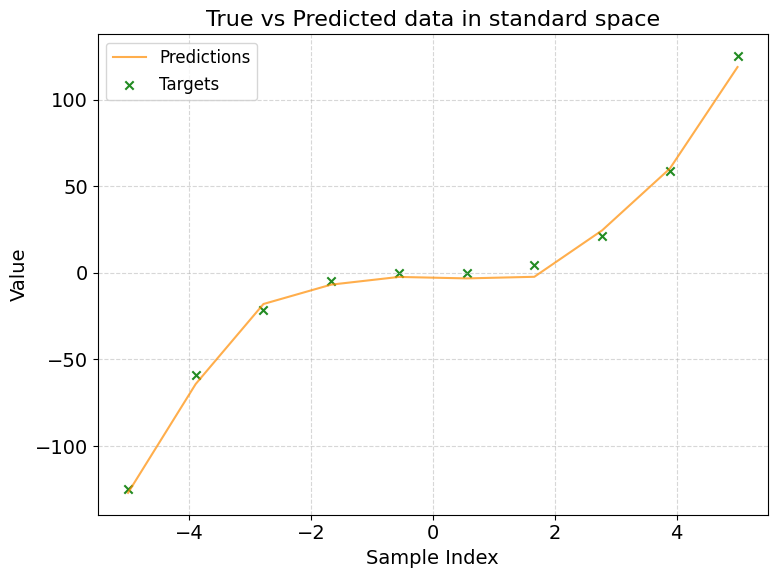

In [799]:
test_predictions_orig = np.array(test_predictions) * np.std(y_train) + np.mean(y_train)

# Plot predictions vs targets
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

# Scatter plot for predictions
plt.plot(x_true_data, test_predictions_orig, label='Predictions', color='darkorange', alpha=0.7)

# Scatter plot for targets
plt.scatter(x_true_data, y_true_data, label='Targets', color='forestgreen', marker='x')

# Labels and legend
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('True vs Predicted data in standard space', fontsize=16)
plt.legend(fontsize=12)

# Grid
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()

In [800]:
# Calcule des métriques.
mse = mean_squared_error(y_true_data, test_predictions_orig)
mae = mean_absolute_error(y_true_data, test_predictions_orig)
r2 = r2_score(y_true_data, test_predictions_orig)

# Afficher les métriques.
print("Metrics:")
print("{:<20} {:.2f}".format("Mean Squared Error:", mse))
print("{:<20} {:.2f}".format("Mean Absolute Error:", mae))
print("{:<20} {:.2f}".format("R-squared:", r2))

Metrics:
Mean Squared Error:  16.30
Mean Absolute Error: 3.60
R-squared:           1.00
